### Simple script to plot reward vs flops for all widths with specific depths

In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("mode.copy_on_write", True)  # to make pandas shut up about making columns
import seaborn as sns

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import sys
sys.path.append('../')
from expt_configs import config_dict, bs_dict, parameterization_dict, dashes_dict

print(f"keys available: {config_dict.keys()}")

keys available: dict_keys(['cartpole_omegaconf_bs', 'ppc_omegaconf_bs', 'ppc_megasweep', 'ant_maze', 'ant_u_maze', 'ant_u4_maze', 'ant_hardest_maze', 'humanoid', 'humanoid_u_maze', 'humanoid_u_maze_long', 'humanoid_big_maze', 'ppc', 'cartpole', 'g1rough_updated', 'humanoid_orthog', 'humanoid_u_maze_orthog', 'humanoid_omegasweep', 'humanoid_u_maze_omegasweep', 'humanoid_u_maze_lrtrans', 'cartpole_10seeds', 'panda_10seeds', 'cartpolesparse_10seeds', 'cheetah_10seeds', 'cheetah_10seeds_26', 'swimmer_10seeds', 'cartpole_omegasweep', 'ppc_omegasweep', 'acrobot_10seeds', 'acrobot_10seeds_26', 'acrobotsparse_10seeds', 'acrobotsparse_10seeds_26', 'cartpole_layernorm', 'ppc_layernorm'])


In [3]:
# choose experiment data
config_name = 'acrobot_10seeds'
plot_dir = "figs"

In [4]:
# load variables and csvs
config = config_dict[config_name]
output_dir = config['output_dir']
env_name = config['env_name']
obs_dim = config['obs_dim']
action_dim = config['action_dim']
num_envs = config['num_envs']
unroll_length = config['unroll_length']
num_minibatches = config['num_minibatches']
update_epochs = config['update_epochs']
num_timesteps = config['num_timesteps']
minibatch_size = config['minibatch_size']
base_layer_size = config['base_layer_size']

os.makedirs(plot_dir, exist_ok=True)
fig_dir = os.path.join(plot_dir, config_name)
os.makedirs(fig_dir, exist_ok=True)
print(f"Made directory {fig_dir}")


csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print(f"Found {len(csv_files)} csv files")

dfs = []
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")
        continue

Made directory figs/acrobot_10seeds
Found 1278 csv files


Length before validating num_minibatches: 50204
Length after validating: 50204
Length before validating unroll_length: 50204
Length after validating: 50204
Length before validating batch_size: 50204
Length after validating: 50204
Length before validating num_timesteps: 50204
Length after validating: 50204
Length before validating num_evals: 50204
Length after validating: 50204
Length before validating step: 50204
Length after validating: 50204
Length before filtering: 50204
Length after filtering: 50204


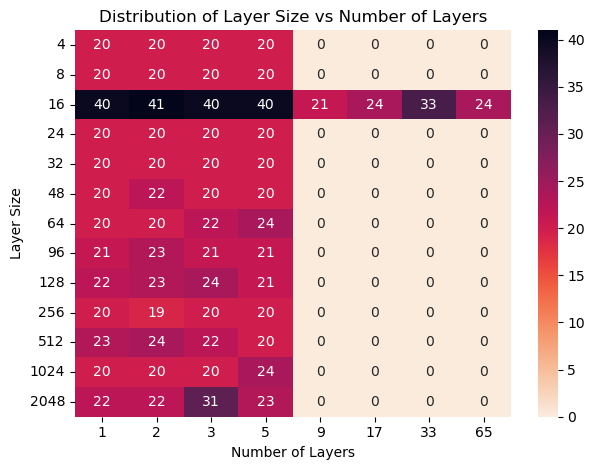

In [5]:
# combine and clean csvs
combined_df = pd.concat(dfs, ignore_index=True)

combined_df = combined_df.dropna(subset=["eval/episode_reward", "num_timesteps"]) 

for double_check_col in ["num_minibatches", "unroll_length", "batch_size", "num_timesteps", "num_evals", "step"]:
    print(f"Length before validating {double_check_col}: {len(combined_df)}")
    combined_df = combined_df[~((combined_df[double_check_col].apply(type) != int) & (combined_df[double_check_col].apply(type) != float))]
    print(f"Length after validating: {len(combined_df)}")

# turn things into ints
combined_df["num_minibatches"] = combined_df["num_minibatches"].astype(int)
combined_df["unroll_length"] = combined_df["unroll_length"].astype(int)
combined_df["batch_size"] = combined_df["batch_size"].astype(int)
combined_df["num_timesteps"] = combined_df["num_timesteps"].astype(int)
combined_df["num_evals"] = combined_df["num_evals"].astype(int)
combined_df["step"] = combined_df["step"].astype(int)
combined_df["eval/episode_reward"] = combined_df["eval/episode_reward"].astype(float)


# total frames calculation TODO: you need the calculation for different timesteps...
# TODO: consider if action repeat should be included in total frames. either way it doesn't count for a second forward pass so we exclude it from optimization calculations and hence FLOP calcs
env_step_per_training_step = combined_df["batch_size"] * combined_df["num_minibatches"] * combined_df["unroll_length"]
num_training_steps_per_epoch = np.ceil(combined_df["num_timesteps"] / ((combined_df["num_evals"] - 1) * env_step_per_training_step)).astype(int)
actual_num_environment_steps = num_training_steps_per_epoch * env_step_per_training_step
actual_num_seen_steps_per_epoch = combined_df["num_updates_per_batch"] * actual_num_environment_steps
combined_df["current_epoch"] = (combined_df['step'] / actual_num_environment_steps).astype(int)
combined_df["total_env_frames"] = actual_num_environment_steps.astype(int) * combined_df["current_epoch"]
combined_df["total_frames"] = actual_num_seen_steps_per_epoch.astype(int) * combined_df["current_epoch"]

# get flops
# we need to calculate FLOPs for the models

def parameter_count_mup_brax(obs_dim, action_dim, layer_size, num_hidden_layers):
    actor_param_count = (obs_dim * layer_size) + (layer_size * action_dim * 2) + (
        (num_hidden_layers - 1) * layer_size**2
    )
    critic_param_count = (obs_dim * layer_size) + layer_size + (
        (num_hidden_layers - 1) * layer_size**2
    )

    total_param_count = actor_param_count + critic_param_count

    return total_param_count

"""
flop count for brax ppo:
FLOPs for forward pass of MLP model with batch size 1: (2 * param count) for linear layers + (2L + 1)N for multiplication scaling
FLOPs for forward pass of resnet model with batch size 1: (2 * param count) for linear layers + (2L + 1)N for multiplication scaling + 2L for residual connections
1 minibatch optimization step: 1 forward pass + 2 forward passes (backward) = 3 forward passes

total flops: 3 * forward pass flops * batch size * num minibatches * unroll length * num updates per batch * num training steps per epoch * current epoch

"""
combined_df['total_param_count'] = parameter_count_mup_brax(
            obs_dim, action_dim, combined_df['layer_size'], combined_df['num_layers']
        )
batch_size_one_forward_pass_flops = 2 * combined_df['total_param_count'] + combined_df['layer_size'] * (combined_df['layer_size'] + 1) + combined_df['layer_size'] * (combined_df['layer_size'] - 1) * combined_df['use_resnet'] # param count + multiply scaling + resnet addition WHICH only gets included if use_resnet is true
combined_df['total_flops'] = (3 * batch_size_one_forward_pass_flops * combined_df['batch_size'] * combined_df['num_minibatches'] * combined_df['unroll_length'] * combined_df['num_updates_per_batch'] * num_training_steps_per_epoch * combined_df['current_epoch']).astype(int)

combined_df['depth'] = combined_df['num_layers'] - 1

# combined_df["width_depth_ratio"] = combined_df["layer_size"] / combined_df["num_layers"]
combined_df["width_depth_ratio"] = combined_df["layer_size"] / combined_df["depth"]
combined_df["width_depth_ratio_log2"] = np.log2(combined_df["width_depth_ratio"])


# env_onestep_flop_count_dict= {"CartpoleSwingup": 3708.0, "PandaPickCube": 172680.0, "G1JoystickRoughTerrain": 2497312.0, "SpotFlatTerrainJoystick": 116963.0, "humanoid": 53748.0, "humanoid_u_maze": 1562711.0, "humanoid_big_maze": 3264566.0, "ant_hardest_maze": 2057127.0, "ant_u_maze": 635011.0, "ant_u4_maze": 805307.0, "arm_binpick_hard": 1942897.0}
# env_onestep_flop_count_dict = {"CartpoleSwingup": 3712.0, "PandaPickCube": 171460.0, "G1JoystickRoughTerrain": 2640817.0, "SpotFlatTerrainJoystick": 124324.0, "CartpoleSwingupSparse": 3654.0, "CheetahRun": 46763.0, "SwimmerSwimmer6": 21958.0, "humanoid": 54779.0, "humanoid_u_maze": 1524722.0, "humanoid_big_maze": 3435293.0, "ant_hardest_maze": 2111963.0, "ant_u_maze": 640799.0, "ant_u4_maze": 866113.0, "arm_binpick_hard": 2003608.0}
env_onestep_flop_count_dict = {"CartpoleSwingup": 3708.0, "PandaPickCube": 172680.0, "G1JoystickRoughTerrain": 2476798.0, "SpotFlatTerrainJoystick": 119252.0, "CartpoleSwingupSparse": 3650.0, "CheetahRun": 46293.0, "SwimmerSwimmer6": 22583.0, "AcrobotSwingup": 4442.0, "AcrobotSwingupSparse": 4436.0, "humanoid": 53748.0, "humanoid_u_maze": 1572027.0, "humanoid_big_maze": 3420728.0, "ant_hardest_maze": 2083439.0, "ant_u_maze": 636961.0, "ant_u4_maze": 830291.0, "arm_binpick_hard": 1942285.0}

combined_df["total_env_flops"] = combined_df["total_env_frames"] * env_onestep_flop_count_dict[env_name]
combined_df['flops_model_and_env'] = combined_df['total_flops'] + combined_df["total_env_flops"]


# FILTERING COMBINED_DF to match num_envs, unroll_length, num_minibatches, update_epochs, num_timesteps, minibatch_size, base_layer_size
# check length before filtering
print(f"Length before filtering: {len(combined_df)}")
combined_df = combined_df[combined_df['num_envs'] == num_envs]
combined_df = combined_df[combined_df['unroll_length'] == unroll_length]
combined_df = combined_df[combined_df['num_minibatches'] == num_minibatches]
combined_df = combined_df[combined_df['num_updates_per_batch'] == update_epochs]
combined_df = combined_df[combined_df['num_timesteps'] == num_timesteps]
combined_df = combined_df[combined_df['batch_size'] == minibatch_size]
combined_df = combined_df[combined_df['base_layer_size'] == base_layer_size]
# check length after filtering
print(f"Length after filtering: {len(combined_df)}")

# Create a heatmap to visualize the distribution
first_step_df = combined_df[combined_df['step'] == 0]
pivot_table = pd.crosstab(first_step_df['layer_size'], first_step_df['num_layers'])
# plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='rocket_r', fmt='d')
plt.title('Distribution of Layer Size vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Layer Size')
plt.tight_layout()
plt.show()

In [6]:
# print depths with more than 3 widths
layer_size_counts = combined_df.groupby('num_layers')['layer_size'].nunique()
Ls = layer_size_counts[layer_size_counts > 2].index.tolist()
print("Depths with more than 3 unique widths:", Ls)


Depths with more than 3 unique widths: [1, 2, 3, 5]


base_lr: 0.01, num_layers: 1


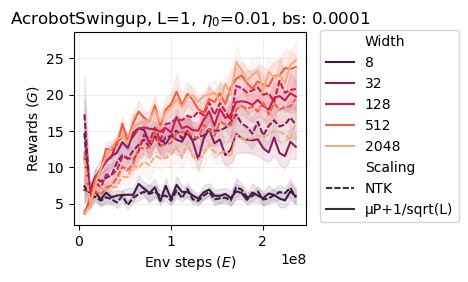

Saved widthscale_AcrobotSwingup_L1_e0.01_bs0.0001
base_lr: 0.01, num_layers: 2


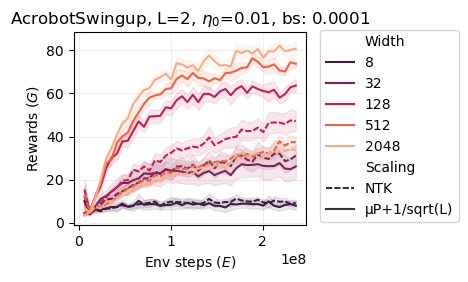

Saved widthscale_AcrobotSwingup_L2_e0.01_bs0.0001
base_lr: 0.01, num_layers: 3


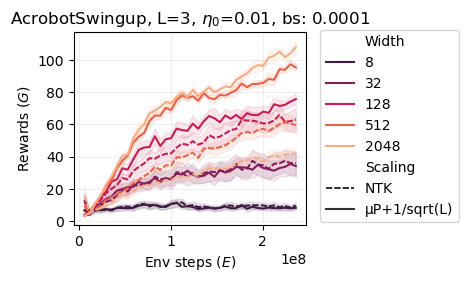

Saved widthscale_AcrobotSwingup_L3_e0.01_bs0.0001
base_lr: 0.01, num_layers: 5


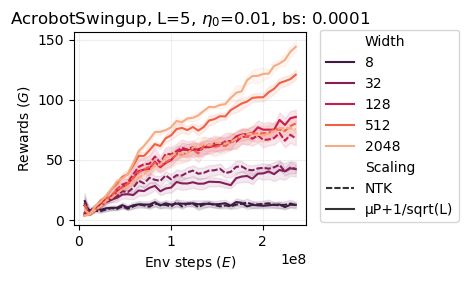

Saved widthscale_AcrobotSwingup_L5_e0.01_bs0.0001


In [ ]:

lrs = [0.01]
# Ns = [4,8,16,24,32,48,64,96, 128, 256, 512, 1024, 2048]
# Ns = [4, 16, 64, 256, 1024]  # subset
Ns = [8, 32, 128, 512, 2048]  # choose subset

ROLLING_WINDOW = 1 # to smoothen

params_to_plot = ['NTK', 'μP+1/sqrt(L)']

# bs_str = 'bias_scaling_0'
bs_str = 'bias_scaling_0.0001'
bias_base_scale = bs_dict[bs_str]['bias_base_scale']
bias_init_fn = bs_dict[bs_str]['bias_init_fn']
use_bias = bs_dict[bs_str]['use_bias']
x_axis = "total_env_frames"

for base_lr in lrs:
    for num_layers in Ls:
        print(f"base_lr: {base_lr}, num_layers: {num_layers}")
        # filter for the following config

        # Incrementally merge filtered_df to be bigger and bigger
        filtered_df = pd.DataFrame()  # start with empty DataFrame
        for param_name, param_dict in parameterization_dict.items():
            if param_name not in params_to_plot:
                continue
            
            filter_config = {
                "base_layer_size": base_layer_size,
                "base_lr": base_lr,
                "base_output_inverse_scaling": 1.0,
                "num_layers": num_layers,
                "init_mode": "normal",
                "activation_str": "relu",
                "use_resnet": True,
                "bias_base_scale": bias_base_scale,
                "bias_init_fn": bias_init_fn,
                "use_bias": use_bias,
                **param_dict,
            }

            # grab all rows that match the filter config
            current_filtered = combined_df[
                combined_df.apply(
                    lambda row: all(
                        row[key] == value for key, value in filter_config.items()
                    ),
                    axis=1,
                )
            ]

            # add a column for the scaling. it will be a combination of ntk_scaling and depth_scaling and how they match up to the parameterization
            current_filtered['Scaling'] = param_name

            # Incrementally merge into filtered_df
            filtered_df = pd.concat([filtered_df, current_filtered], ignore_index=True)

        interp_dfs = []

        # group the dataframe by specific columns
        for (scaling, ntk_scaling, depth_scaling, layer_size, seed), group_df in filtered_df.groupby(
            ["Scaling", "ntk_scaling", "depth_scaling", "layer_size", "seed"]
        ):
            mean_group_df = group_df.groupby('step', as_index=False).mean(numeric_only=True)
            # sort the group by step to ensure proper ordering
            sorted_group_df = mean_group_df.sort_values(by="step")
            # calculate the rolling average on the interpolated values
            smoothed_returns = (
                sorted_group_df["eval/episode_reward"]
                .rolling(window=ROLLING_WINDOW, closed="left")
                .mean()
            )
            # print(smoothed_returns.shape)

            temp_df = pd.DataFrame(
                {
                    "step": sorted_group_df["step"],
                    x_axis: sorted_group_df[x_axis],
                    "eval/episode_reward": sorted_group_df["eval/episode_reward"],
                    "smoothed_returns": smoothed_returns,
                    "ntk_scaling": ntk_scaling,
                    "layer_size": layer_size,
                    "seed": seed,
                    "Scaling": scaling,
                    "depth_scaling": depth_scaling,
                }
            )

            interp_dfs.append(temp_df)


        if len(interp_dfs) <= 0:
            print(f"No data found for base_lr: {base_lr}, num_layers: {num_layers}")
            continue

        interp_df = pd.concat(interp_dfs, ignore_index=True)

        # filter out layer size according to values in Ns
        interp_df = interp_df[interp_df['layer_size'].isin(Ns)]

        # drop the nan values
        interp_df = interp_df.dropna(subset=["smoothed_returns"])

        # Setup a custom color palette based on the unique values of layer_size.
        layer_size_order = sorted(interp_df["layer_size"].unique())
        colors = sns.color_palette("rocket", n_colors=len(layer_size_order))
        color_mapping = dict(zip(layer_size_order, colors))

        # plot formatting
        interp_df = interp_df.rename(columns={'layer_size': 'Width'})
        
        interp_df['Width'] = interp_df['Width'].astype(int)
        # plt.rc('text', usetex=True)  # Enable LaTeX rendering
        # # You might also need this if you get font warnings:
        # plt.rc('font', family='serif')


        plt.figure(figsize=(3, 2.5))
        ax = sns.lineplot(
            data=interp_df,
            x=x_axis,
            y="smoothed_returns",
            hue="Width",
            style="Scaling",
            palette=color_mapping,
            alpha=1,
            errorbar=(
                "se",
                1,
            ),  # This creates error bands reflecting the confidence intervals over runs.
            err_kws={'alpha': 0.1},
            dashes=dashes_dict,
        )

        plt.grid(alpha=0.2)

        plt.legend(bbox_to_anchor=(1.03, 1.05), loc="upper left",)

        # Add a title and axis labels
        plt.title(f"{env_name}, L={num_layers}, $\eta_0$={base_lr}, bs: {bias_base_scale}")
        plt.xlabel("Env steps ($E$)")
        plt.ylabel("Rewards ($G$)")
        filename = f"widthscale_{env_name}_L{num_layers}_e{base_lr}_bs{bias_base_scale}"
        # plt.savefig(f'{fig_dir}/{filename}.png', bbox_inches="tight",dpi=300)
        plt.show()
        plt.close()
        print(f"Saved {filename}")

(40,) (40,)
(40,) (40,)


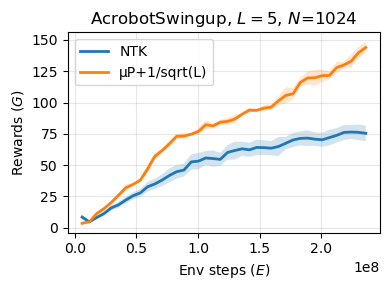

In [ ]:
# Filter for NTK and μP+1/sqrt(L) scaling and layer_size=1024 for dormant neuron analysis
scalings_to_plot = ['NTK', 'μP+1/sqrt(L)']
plot_df = interp_df[
    (interp_df['Scaling'].isin(scalings_to_plot)) &
    (interp_df['Width'] == 2048) 
]

plt.figure(figsize=(4, 3))
for scaling in scalings_to_plot:
    sub_df = plot_df[plot_df['Scaling'] == scaling]
    grouped = sub_df.groupby(x_axis)["smoothed_returns"].agg(['mean', 'sem']).reset_index()
    plt.plot(grouped[x_axis], grouped['mean'], label=scaling, linewidth=2)
    plt.fill_between(grouped[x_axis], grouped['mean'] - grouped['sem'], grouped['mean'] + grouped['sem'], alpha=0.2)
    print(grouped[x_axis].shape, grouped['mean'].shape  )

plt.grid(alpha=0.3)
plt.legend()
plt.title(f"{env_name}, $L={num_layers}$, $N$=1024")
plt.xlabel("Env steps ($E$)")
plt.ylabel("Rewards ($G$)")
plt.tight_layout()
# plt.savefig(f'{fig_dir}/compare_reward_{env_name}_L{num_layers}_N1024.pdf', bbox_inches="tight")


x_axis: flops_model_and_env, hue_variable: total_param_count


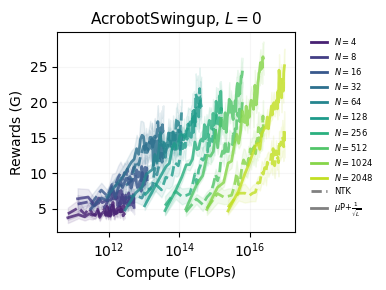

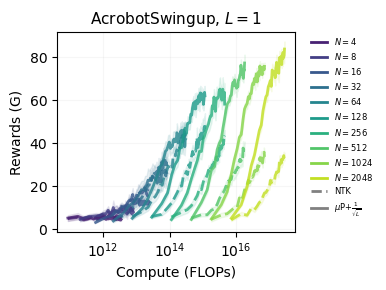

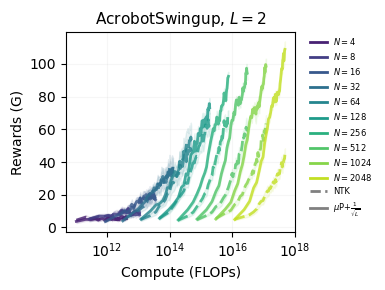

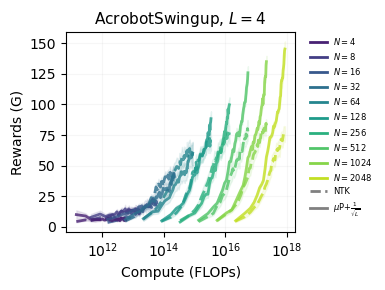

In [16]:
Ns = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]


use_resnet = True
depth_scaling = True
base_lr = 0.01
bs_str = 'bias_scaling_0.0001'
bias_base_scale = bs_dict[bs_str]['bias_base_scale']
bias_init_fn = bs_dict[bs_str]['bias_init_fn']
use_bias = bs_dict[bs_str]['use_bias']

x_axis, hue_variable = 'flops_model_and_env', 'total_param_count'
print(f"x_axis: {x_axis}, hue_variable: {hue_variable}")

for L in Ls:  # Changed from enumerate(Ls) to just Ls
    rewards = np.zeros([2, 13, 40])
    reward_dev = np.zeros_like(rewards)
    flops = np.zeros_like(rewards)
    model_params = np.zeros(13)

    filter_config = {
        "base_layer_size": base_layer_size,
        "base_lr": base_lr,
        "base_output_inverse_scaling": 1.0,
        "init_mode": "normal",
        "activation_str": "relu",
        "use_resnet": use_resnet,
        "bias_base_scale": bias_base_scale,
        "bias_init_fn": bias_init_fn,
        "use_bias": use_bias,
        "num_envs": num_envs,
        "num_minibatches": num_minibatches,
        "unroll_length": unroll_length,
        "num_timesteps": num_timesteps,
        "num_updates_per_batch": update_epochs,
        "use_resnet": use_resnet,
        "num_layers": L,
        "num_timesteps": num_timesteps,
        "bias_init_fn": bias_init_fn,
        "use_bias": use_bias,
    }

    filtered_df = combined_df[
        combined_df.apply(
            lambda row: all(row[key] == value for key, value in filter_config.items()),
            axis=1,
        )
    ].query('step != 0')

    # filter out layer size according to values in Ns
    filtered_df = filtered_df[filtered_df['layer_size'].isin(Ns)]

    # Get unique hue values from ACTUAL data
    hue_values = sorted(filtered_df[hue_variable].unique())
    # colors = sns.color_palette('rocket', n_colors=len(hue_values))
    colors = sns.color_palette('viridis', n_colors=len(hue_values))
    color_mapping = dict(zip(hue_values, colors))

    plt.figure(figsize=(4, 3))

    for i,(ntk_val, depth_scaling) in enumerate([(True, False), (False, True)]):
        ntk_df = filtered_df[
            (filtered_df['ntk_scaling'] == ntk_val) &
            (filtered_df['depth_scaling'] == depth_scaling)]

        for j, hue_val in enumerate(hue_values):  # Iterate through actual values present
            group_df = ntk_df[ntk_df[hue_variable] == hue_val]
            
            if group_df.empty:
                continue
                
            agg_df = group_df.groupby(x_axis)['eval/episode_reward'].agg(['mean', 'std', 'count'])
            x_values = agg_df.index.values
            y_values = agg_df['mean'].values
            y_err = agg_df['std'].values / np.sqrt(agg_df['count'].values)
            
            color = color_mapping[hue_val]
            line_style = '--' if ntk_val else '-'
            
            plt.plot(x_values, y_values,
                    color=color,
                    linestyle=line_style,
                    linewidth=2,
                    alpha=0.8)
            
            plt.fill_between(x_values, 
                           y_values - y_err, 
                           y_values + y_err,
                           color=color,
                           alpha=0.1)

            rewards[i, j] = y_values
            reward_dev[i, j] = y_err
            flops[i, j] = x_values
            model_params[j] = hue_val

    plt.xscale('log')
    plt.xlabel('Compute (FLOPs)', fontsize=10)
    plt.ylabel('Rewards (G)', fontsize=10)
    plt.grid(True, alpha=0.1)
    plt.title(f"{env_name}, $L={L-1}$", fontsize=11)  # L is now the actual layer count

    legend_elements = [
        *[Line2D([0], [0], color=color, lw=2, label=f'$N={Ns[i]}$')
         for i, (hue_val, color) in enumerate(color_mapping.items())],
        Line2D([0], [0], color='gray', linestyle='--', lw=2, label='NTK'),
        Line2D([0], [0], color='gray', linestyle='-', lw=2, label='$\mu$P$+\\frac{1}{\\sqrt{L}}$')
    ]

    plt.legend(handles=legend_elements, 
              bbox_to_anchor=(1.05, 1), 
              loc='upper left', 
              borderaxespad=0.,
              frameon=False,
              fontsize=6)

    plt.tight_layout()
    plt.savefig(f'{fig_dir}/{env_name}_{L}L_width_{base_lr}lr.pdf', 
               bbox_inches='tight')

    np.savez(f"{fig_dir}/{env_name}_{L}L_width_{base_lr}lr.npz",
             rewards=rewards,
             reward_dev=reward_dev,
             flops=flops, model_params=model_params)